In [9]:
from __future__ import print_function

# Standard modules
import os
import pickle
import numpy as np
import nibabel as nib

# Dipy modules
import dipy.viz.regtools as rt
import dipy.align.imwarp as imwarp
from dipy.align import VerbosityLevels
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import regtransforms

# EPI correction (new) modules
import dipy.correct.gradients as gr
from dipy.correct.splines import CubicSplineField
from dipy.correct.epicor import (OppositeBlips_CC,
                                 OffResonanceFieldEstimator)
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
floating = np.float64

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [10]:
# Load data
data_dir = '/home/omar/data/topup_example/'
up_fname = data_dir + "b0_blipup.nii"
down_fname = data_dir + "b0_blipdown.nii"

up_nib = nib.load(up_fname)
up_affine = up_nib.get_affine()
direction, spacings = imwarp.get_direction_and_spacings(up_affine, 3)
up = up_nib.get_data().squeeze().astype(np.float64)

down_nib = nib.load(down_fname)
down_affine = down_nib.get_affine()
down = down_nib.get_data().squeeze().astype(np.float64)

In [11]:
# Parameters
radius = 4
level_iters = [200, 200, 200, 200, 200, 200, 200, 200, 200]
lambdas = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                   0.5, 0.05, 0.05])*300
fwhm = np.array([8, 6, 4, 3, 3, 2, 1, 0, 0])

pedir_up = np.array((0,1,0), dtype=np.float64)
pedir_down = np.array((0,-1,0), dtype=np.float64)

# Preprocess intensities
up /= up.mean()
down /= down.mean()

# Configure and run orfield estimation
distortion_model = OppositeBlips_CC(radius=radius)
estimator = OffResonanceFieldEstimator(distortion_model, level_iters=level_iters, lambdas=lambdas, fwhm=fwhm)

In [12]:
# Optimize or load results
orfield_coef_fname = 'orfield_coef_new_ss.p'
if os.path.isfile(orfield_coef_fname):
    coef = pickle.load(open(orfield_coef_fname, 'r'))
    kspacing = np.round(estimator.warp_res[-1]/spacings)
    kspacing = kspacing.astype(np.int32)
    kspacing[kspacing < 1] = 1
    orfield = CubicSplineField(up.shape, kspacing)
    orfield.copy_coefficients(coef)
else:
    orfield = estimator.optimize_with_ss(down, down_affine, pedir_down, up, up_affine, pedir_up, spacings)
    pickle.dump(np.array(orfield.coef), open(orfield_coef_fname, 'w'))

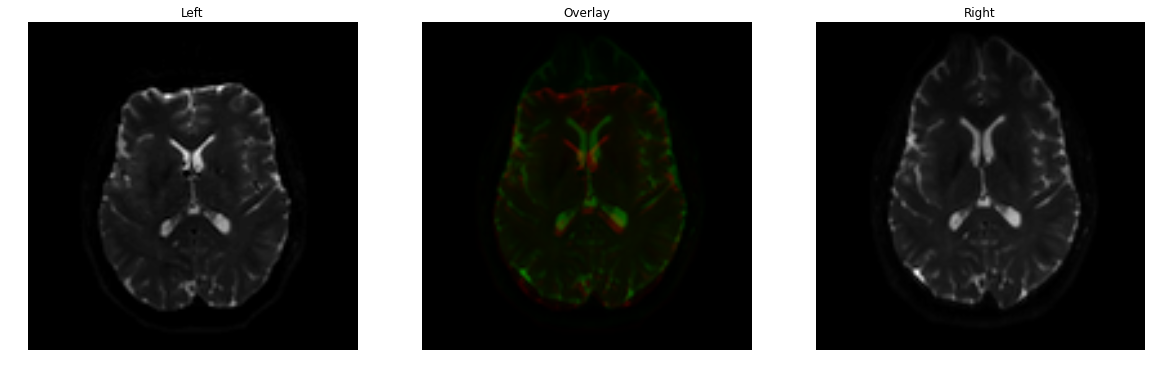

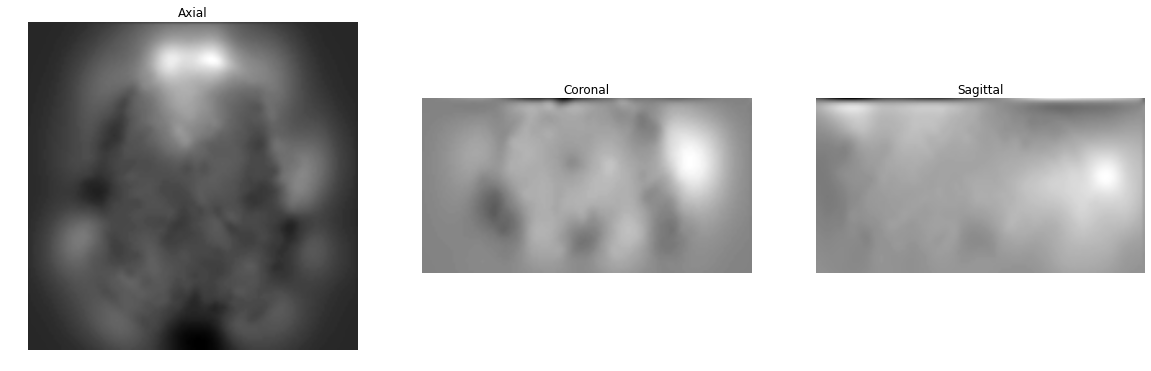

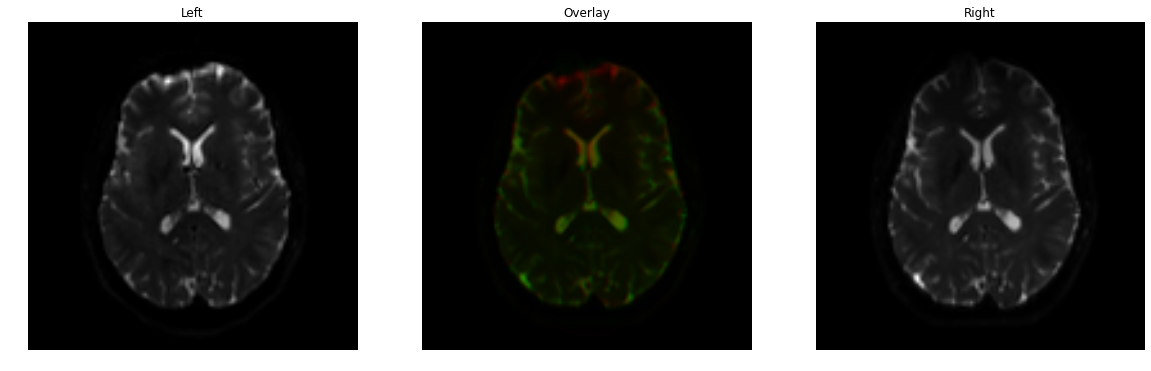

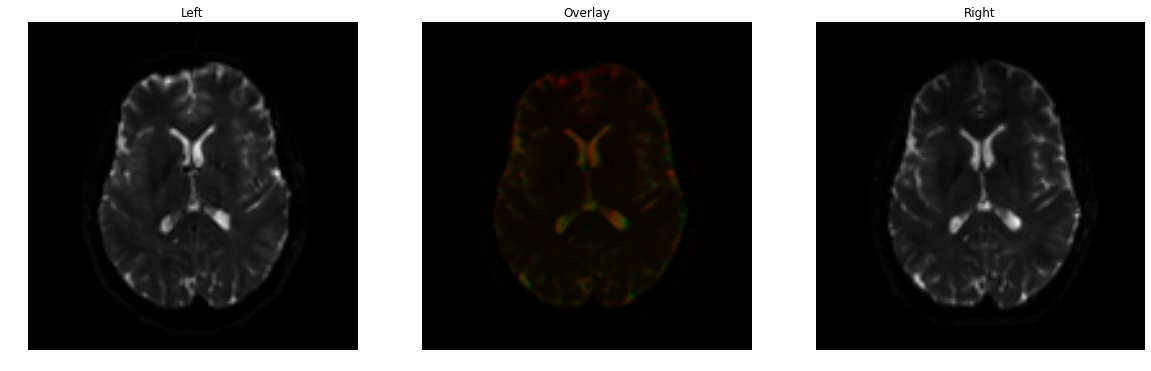

In [13]:
# Warp and modulte images
b  = np.array(orfield.get_volume((0, 0, 0)))
db = np.array(orfield.get_volume((0, 1, 0)))
shape = np.array(up.shape, dtype=np.int32)
w_up, _m = gr.warp_with_orfield(up, b, pedir_up, None,
                                None, None, shape)
w_down, _m = gr.warp_with_orfield(down, b, pedir_down, None,
                                  None, None, shape)
rt.overlay_slices(down, up, slice_type=2);
rt.plot_slices(b);
rt.overlay_slices(w_down, w_up, slice_type=2);

Jdown = (1.0-db)
Jup = (1.0+db)
Jdown[Jdown<0] = 0
Jup[Jup<0] = 0
rt.overlay_slices(w_down*Jdown, w_up*Jup, slice_type=2);


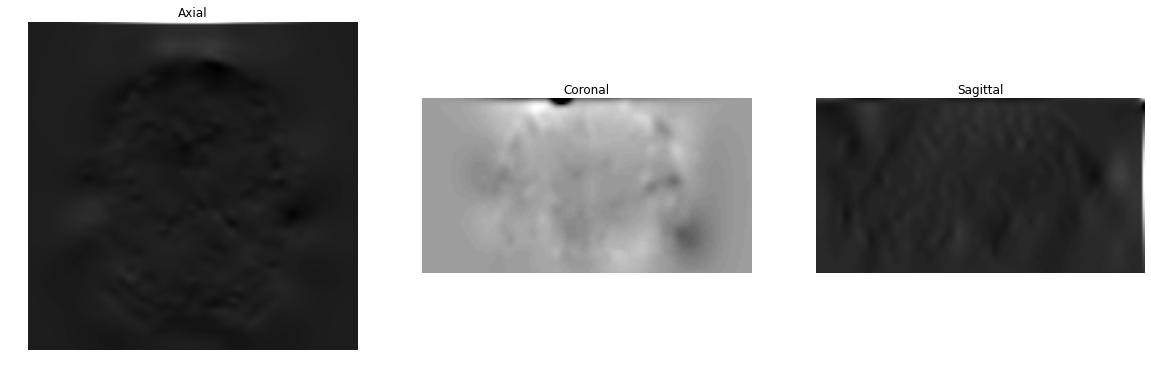

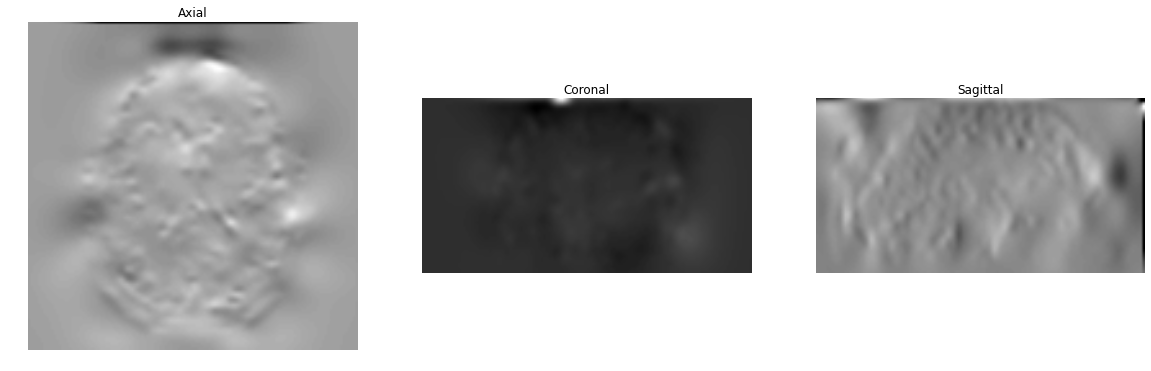

In [14]:
rt.plot_slices(Jdown);
rt.plot_slices(Jup);

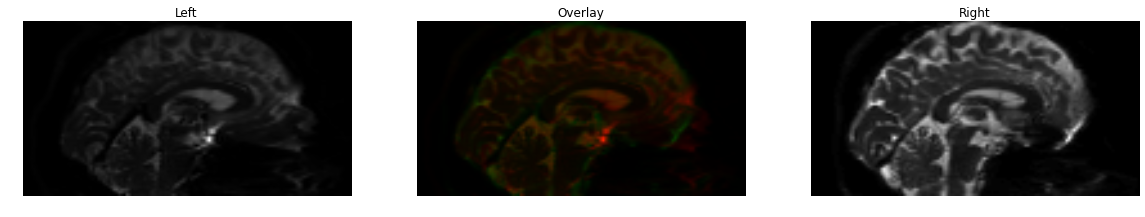

In [15]:
rt.overlay_slices(w_down*Jdown, w_up*Jup, slice_type=0);